In [1]:
import seg_metrics.seg_metrics as sg
import pandas as pd
import numpy as np
import nibabel as nib
import os
import pydicom
from skimage import morphology
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import cv2
from skimage.morphology import skeletonize, skeletonize_3d

C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable O

In [2]:
import pickle
from sklearn.metrics import brier_score_loss
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle
from skimage import morphology
import glob
from sklearn.metrics import r2_score
import scipy
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

In [3]:
import seaborn as sns
from scipy import stats

In [4]:
def icc(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

In [5]:
def cl_score(v, s):
    """[this function computes the skeleton volume overlap]
    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]
    Returns:
        [float]: [computed skeleton volume intersection]
    """
    return np.sum(v*s)/np.sum(s)


def clDice(v_p, v_l):
    """[this function computes the cldice metric]
    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]
    Returns:
        [float]: [cldice metric]
    """
    if len(v_p.shape)==2:
        tprec = cl_score(v_p,skeletonize(v_l))
        tsens = cl_score(v_l,skeletonize(v_p))
    elif len(v_p.shape)==3:
        tprec = cl_score(v_p,skeletonize_3d(v_l))
        tsens = cl_score(v_l,skeletonize_3d(v_p))
    return 2*tprec*tsens/(tprec+tsens)

In [6]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

In [7]:
def find_contours(img_input):
    
    dim = img_input.shape
    img_b = np.zeros(dim, dtype=np.uint8)
    
    coords_mask = np.where(img_input>0)
    
    for i in range(0, len(coords_mask[0])):
        
        if np.sum(img_input[coords_mask[0][i]-1:coords_mask[0][i]+2, 
                            coords_mask[1][i]-1:coords_mask[1][i]+2, 
                            coords_mask[2][i]-1:coords_mask[2][i]+2])<18:
            img_b[coords_mask[0][i], coords_mask[1][i], coords_mask[2][i]] = 1
            
    return img_b

def nsd(img_1, img_2, tau):
    
    img_1_b = find_contours(img_1)
    img_2_b = find_contours(img_2)
    
    strel_size = 1 + tau*2
    strel = np.ones((strel_size, strel_size, strel_size))
    
    img_1_bb = morphology.binary_dilation(img_1_b, strel)
    img_2_bb = morphology.binary_dilation(img_2_b, strel)
    
    int_1 = img_1_b*img_2_bb
    int_2 = img_1_bb*img_2_b
    
    return (np.sum(int_1)+np.sum(int_2))/(np.sum(img_1_b) + np.sum(img_2_b))

In [8]:
def get_scores(metrics_df, dir_gt, dir_pred, dir_sm):
    volumes_gt = []
    volumes_pred = []
    clDSCs = []
    #bscs = []
    nsds = []
    for filename in metrics_df.filename:
        item = os.path.split(filename)[-1]
        filename_gt = os.path.join(dir_gt,item)
        filename_pred = os.path.join(dir_pred,item)
        filename_sm = os.path.join(dir_sm,item)
        nii_gt = nib.load(filename_gt)
        nii_pred = nib.load(filename_pred)
        nii_sm = nib.load(filename_sm)
        array_gt = nii_gt.get_fdata()
        array_pred = nii_pred.get_fdata()
        array_sm = nii_sm.get_fdata()
        volume_gt = np.sum(array_gt>0)
        volume_pred = np.sum(array_pred)
        clDSCs.append(clDice(array_gt, array_pred)) 
        volumes_gt.append(volume_gt)
        volumes_pred.append(volume_pred)
        #bscs.append(brier_score_loss(array_gt.flatten(), array_sm.flatten()))
        nsds.append(nsd(array_gt, array_pred, 2))
    metrics_df['volume_gt'] = volumes_gt
    metrics_df['volume_pred'] = volumes_pred
    metrics_df['volume_error'] = np.abs(np.array(volumes_gt) - np.array(volumes_pred))
    metrics_df['clDice'] = clDSCs
    #metrics_df['Brier'] = bscs
    metrics_df['NSD'] = nsds

    icc_score = icc(np.column_stack((volumes_gt, volumes_pred)), icc_type='ICC(2,k)')
    
    scores_median = metrics_df[scorenames].median()
    scores_median['icc'] = icc_score
    
    Q1 = metrics_df[scorenames].quantile(0.25)
    Q3 = metrics_df[scorenames].quantile(0.75)
    scores_iqr = Q3 - Q1
    
    return scores_median, scores_iqr

In [9]:
def dirname2scores(dirname_gt, dirname_pred, dirname_sm, filename_metrics):
    metrics = sg.write_metrics(labels=[1], gdth_path=dirname_gt, pred_path=dirname_pred, csv_file=filename_metrics)
    metrics_dataframe = pd.read_csv(filename_metrics)
    scores_median, scores_iqr = get_scores(metrics_dataframe, dirname_gt, dirname_pred, dirname_sm)
    return scores_median, scores_iqr, metrics_dataframe

In [10]:
scorenames = ['dice', 'jaccard', 'precision', 'recall', 'fpr', 'fnr', 'vs', 'hd', 'msd', 'mdsd', 'stdsd', 'hd95',
              'volume_error', 'clDice', 'NSD']

In [11]:
def calculate_area_diameter(mask):
    mask_labeled = label(mask)
    regions = regionprops(mask_labeled)
    area_max = 0
    diameter_max = 0
    for r in regions:
        diameter = r.axis_major_length
        area = r.area
        if area>area_max:
            area_max = area
            diameter_max = diameter
    return area_max, diameter_max

In [12]:
def get_2Dscores(metrics_df, dir_gt, dir_pred):
    areas = []
    diameters = []
    dscs = []
    for filename in metrics_df.filename:
        item = os.path.split(filename)[-1]
        filename_gt = os.path.join(dir_gt,item)
        filename_pred = os.path.join(dir_pred,item)
        nii_gt = nib.load(filename_gt)
        nii_pred = nib.load(filename_pred)
        array_gt = nii_gt.get_fdata()
        array_pred = nii_pred.get_fdata()
        for i in range(array_gt.shape[2]):
            dsc = calculate_dice(array_gt[..., i], array_pred[..., i])
            a, d = calculate_area_diameter(array_gt[..., i])
            areas.append(a*0.303030*0.303030)
            diameters.append(d)
            dscs.append(dsc)
    return areas, diameters, dscs
            

In [13]:
def get_median_percentile_area_dice(areas_list, dscs_list, 
                                    bin_area_min = 25, bin_area_max = 200, bin_area_step = 25, ci = 90):
    
    bin_areas = np.arange(bin_area_min, bin_area_max+1, bin_area_step)
    
    bin_dscs = []
    for j in range (0, len(bin_areas)-1):
        bin1_dscs = []
        for i in range(0, len(areas_list)):
            if (areas_list[i]>bin_areas[j]) and (areas_list[i]<=bin_areas[j+1]):
                bin1_dscs.append(dscs_list[i])
        bin_dscs.append(bin1_dscs)

    bin_dscs_median = []
    bin_dscs_low = []
    bin_dscs_high = []
    p_low = (100-ci)/2
    p_high = 100-p_low
    for i in range (0, len(bin_dscs)):
        bin_dscs_median.append(np.nanmedian(bin_dscs[i]))
        bin_dscs_low.append(np.percentile(bin_dscs[i], p_low))
        bin_dscs_high.append(np.percentile(bin_dscs[i], p_high))
        
    return bin_areas, bin_dscs_median, bin_dscs_low, bin_dscs_high
            


In [14]:
def get_dice(img_1, img_2):
    return np.sum(img_1[img_2==1])*2.0 / (np.sum(img_1) + np.sum(img_2))

In [15]:
def scatter_dice_area(scores_df_1, scores_df_2, scores_df_3, scores_df_4, 
                      dirname_gt_1, dirname_gt_2, dirname_gt_3, dirname_gt_4,
                      dirname_1, dirname_2, dirname_3, dirname_4):
    
    areas_test, diameters_test, dscs_test = get_2Dscores(scores_df_1, dirname_gt_1, dirname_1)
    areas_t2w, diameters_t2w, dscs_t2w = get_2Dscores(scores_df_2, dirname_gt_2, dirname_2)
    areas_t1wce, diameters_t1wce, dscs_t1wce = get_2Dscores(scores_df_3, dirname_gt_3, dirname_3)
    areas_emc, diameters_emc, dscs_emc = get_2Dscores(scores_df_4, dirname_gt_4, dirname_4)

    plt.figure(figsize=(17, 4))
    plt.subplot(141)
    xy = np.vstack([areas_test, dscs_test])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_test, dscs_test, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    plt.ylabel('DSC')
    plt.title('T1w')
    plt.subplot(142)
    xy = np.vstack([areas_t2w, dscs_t2w])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_t2w, dscs_t2w, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T2w')
    plt.subplot(143)
    xy = np.vstack([areas_t1wce, dscs_t1wce])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_t1wce, dscs_t1wce, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w CE')
    plt.subplot(144)
    xy = np.vstack([areas_emc, dscs_emc])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_emc, dscs_emc, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w external')
    plt.suptitle('nnUNet DSC with regards to CA area')
    plt.show()

In [16]:
def plot_dice_area(scores_df_1, scores_df_2, scores_df_3, scores_df_4, 
                   dirname_gt_1, dirname_gt_2, dirname_gt_3, dirname_gt_4,
                   dirname_1, dirname_2, dirname_3, dirname_4):
    
    areas_test, diameters_test, dscs_test = get_2Dscores(scores_df_1, dirname_gt_1, dirname_1)
    areas_t2w, diameters_t2w, dscs_t2w = get_2Dscores(scores_df_2, dirname_gt_2, dirname_2)
    areas_t1wce, diameters_t1wce, dscs_t1wce = get_2Dscores(scores_df_3, dirname_gt_3, dirname_3)
    areas_emc, diameters_emc, dscs_emc = get_2Dscores(scores_df_4, dirname_gt_4, dirname_4)

    bin_areas_test,bin_dscs_median_test,bin_dscs_low_test,bin_dscs_high_test = get_median_percentile_area_dice(areas_test, 
                                                                                                                  dscs_test)
    bin_areas_t2w,bin_dscs_median_t2w,bin_dscs_low_t2w,bin_dscs_high_t2w = get_median_percentile_area_dice(areas_t2w, 
                                                                                                           dscs_t2w)
    bin_areas_t1wce,bin_dscs_median_t1wce,bin_dscs_low_t1wce,bin_dscs_high_t1wce = get_median_percentile_area_dice(areas_t1wce,
                                                                                                                   dscs_t1wce)
    bin_areas_emc,bin_dscs_median_emc,bin_dscs_low_emc,bin_dscs_high_emc = get_median_percentile_area_dice(areas_emc, 
                                                                                                           dscs_emc, 
                                                                                                           bin_area_min = 0, 
                                                                                                           bin_area_max = 400, 
                                                                                                           bin_area_step = 50)

    plt.figure(figsize=(17, 4))
    plt.subplot(141)
    p1 = plt.plot(bin_areas_test[1:], bin_dscs_median_test)
    plt.fill_between(bin_areas_test[1:], bin_dscs_high_test, bin_dscs_low_test, alpha = 0.3)
    plt.xlabel('CA area, mm$^{2}$')
    plt.ylabel('DSC')
    plt.title('T1w')
    rect_ci = Rectangle((0,0), 0,0, alpha=0.3)
    objects = [p1[0], rect_ci]
    labels = ['Median', '90% CI']
    plt.legend(objects, labels, loc='lower right')
    plt.subplot(142)
    plt.plot(bin_areas_t2w[1:], bin_dscs_median_t2w)
    plt.fill_between(bin_areas_t2w[1:], bin_dscs_high_t2w, bin_dscs_low_t2w, alpha = 0.3)
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T2w')
    plt.legend(objects, labels, loc='lower right')
    plt.subplot(143)
    plt.plot(bin_areas_t1wce[1:], bin_dscs_median_t1wce)
    plt.fill_between(bin_areas_t1wce[1:], bin_dscs_high_t1wce, bin_dscs_low_t1wce, alpha = 0.3)
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w CE')
    plt.legend(objects, labels, loc='lower right')
    plt.subplot(144)
    plt.plot(bin_areas_emc[1:], bin_dscs_median_emc)
    plt.fill_between(bin_areas_emc[1:], bin_dscs_high_emc, bin_dscs_low_emc, alpha = 0.3)
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w external')
    plt.legend(objects, labels, loc='lower right')
    plt.suptitle('nnUNet DSC with regards to CA area')
    plt.show()

In [17]:
def plot_volume_regression(df_1, df_2, df_3, df_4):
    
    plt.figure(figsize=(16, 4))

    plt.subplot(141)
    ax = sns.regplot(x=np.array(df_1['volume_gt'])/1000, y=np.array(df_1['volume_pred'])/1000, 
                     line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% CI')
    plt.legend(loc = 'lower right')
    plt.xlabel('Manual segmentation volume, $cm^3$')
    plt.ylabel('Autosegmentation volume, $cm^3$')
    plt.title('T1w, $R^2$ = '+str(round(scipy.stats.linregress(np.array(df_1['volume_gt']), 
                                                          np.array(df_1['volume_pred']))[2], 2)))

    plt.subplot(142)
    ax = sns.regplot(x=np.array(df_2['volume_gt'])/1000, y=np.array(df_2['volume_pred'])/1000, 
                     line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% CI')
    plt.legend(loc = 'lower right')
    plt.xlabel('Manual segmentation volume, $cm^3$')
    plt.ylabel('')
    plt.title('T2w, $R^2$ = '+str(round(scipy.stats.linregress(np.array(df_2['volume_gt']), 
                                                          np.array(df_2['volume_pred']))[2], 2)))

    plt.subplot(143)
    ax = sns.regplot(x=np.array(df_3['volume_gt'])/1000, y=np.array(df_3['volume_pred'])/1000, 
                     line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% CI')
    plt.legend(loc = 'lower right')
    plt.xlabel('Manual segmentation volume, $cm^3$')
    plt.ylabel('')
    plt.title('T1w CE, $R^2$ = '+str(round(scipy.stats.linregress(np.array(df_3['volume_gt']), 
                                                          np.array(df_3['volume_pred']))[2], 2)))

    plt.subplot(144)
    ax = sns.regplot(x=np.array(df_4['volume_gt'])/1000, y=np.array(df_4['volume_pred'])/1000, 
                     line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% CI')
    plt.legend(loc = 'lower right')
    plt.xlabel('Manual segmentation volume, $cm^3$')
    plt.ylabel('')
    plt.title('T1w EMC, $R^2$ = '+str(round(scipy.stats.linregress(np.array(df_4['volume_gt']), 
                                                          np.array(df_4['volume_pred']))[2], 2)))

    plt.show()

In [18]:
def get_dropout_dice(dirname_gt, dirname_do):
    
    sub_names = []

    for item in os.listdir(dirname_gt):
        sub_names.append(item[:-7])
        
        dscs_df = []

    for sub_name in sub_names:

        filenames_sub = glob.glob(dirname_do + sub_name + '*.nii.gz')
        n = len(filenames_sub)

        filename_gt = dirname_gt + sub_name + '.nii.gz'
        gt_nii = nib.load(filename_gt)
        gt = gt_nii.get_fdata()
        dim = gt.shape

        preds_array = np.zeros((dim[0], dim[1], dim[2], n), dtype = np.float32)
        for i in range (0, n):
            preds_array[..., i] = nib.load(filenames_sub[i]).get_fdata()

        pred_mean = np.mean(preds_array, axis = 3)
        dsc_mean = get_dice(gt, pred_mean)

        dscs = []
        for i in range (0, n):
            dscs.append(get_dice(pred_mean, preds_array[..., i]))
        dsc_ws = np.mean(dscs)

        rec = {'sub': sub_name, 'dsc_mean': dsc_mean, 'dsc_ws': dsc_ws}
        dscs_df.append(rec)

    dscs_df = pd.DataFrame(dscs_df)

    print (np.mean(dscs_df['dsc_ws']))
    
    #plt.plot((0.5, 1.0), (0.5, 1.0), ':k')
    plt.ylim(0.0, 1.0)
    plt.xlim(0.0, 1.0)
    plt.plot((0, 1), (0, 1), color='w', alpha = 0)
    plt.scatter(dscs_df['dsc_ws'], dscs_df['dsc_mean'], c = 'yellow', edgecolors = 'navy', s = 50)
    plt.xlabel('DSC within samples')
    plt.ylabel('DSC mean')
    plt.axis('square')
   



In [19]:
def bland_altman_plot(x_1, x_2, unit):
    
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    mean = np.mean([x_1, x_2], axis=0)
    diff = x_1 - x_2                   
    md = np.mean(diff)                  
    sd = np.std(diff, axis=0) 

    plt.scatter(mean, diff, edgecolor="navy")
    plt.axhline(md, color='gray', linestyle='-', label='MD: '+str(round(md, 2)))
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label='MD + 1.96SD: '+str(round(md + 1.96*sd, 2)))
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--', label='MD - 1.96SD: '+str(round(md - 1.96*sd, 2)))
    plt.legend(loc = 'lower right', framealpha=0)
    plt.xlabel('Average, ' + unit)
    plt.ylabel('Difference, ' + unit)
    

In [78]:
def plot_ba(df_1, df_2, df_3, df_4):
    
    plt.figure(figsize=(16, 4))

    plt.subplot(141)
    bland_altman_plot(df_1['volume_gt']/1000, df_1['volume_pred']/1000, 'cm3')
    plt.title('T1w')

    plt.subplot(142)
    bland_altman_plot(df_2['volume_gt']/1000, df_2['volume_pred']/1000, 'cm3')
    plt.title('T2w')
    plt.ylabel('')

    plt.subplot(143)
    bland_altman_plot(df_3['volume_gt']/1000, df_3['volume_pred']/1000, 'cm3')
    plt.title('T1w CE')
    plt.ylabel('')

    plt.subplot(144)
    bland_altman_plot(df_4['volume_gt']/1000, df_4['volume_pred']/1000, 'cm3')
    plt.title('T1w EMC')
    plt.ylabel('')

    plt.show()
    
    

## nnUNet

In [59]:
nifti_dirname_GT_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_GT"
nifti_dirname_GT_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_GT"
nifti_dirname_GT_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_GT"

nifti_dirname_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_nnunet"
nifti_dirname_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_nnunet"
nifti_dirname_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_nnunet"
nifti_dirname_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_nnunet"

nifti_dirname_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_nnunet_p"
nifti_dirname_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_nnunet_p"
nifti_dirname_t1wce_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_nnunet_p"
nifti_dirname_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_nnunet_p"

In [60]:
scores_median_test_1, scores_iqr_test_1, scores_df_test_1 = dirname2scores(nifti_dirname_GT_test, nifti_dirname_test, 
                                                                           nifti_dirname_test_sm,
                                                                           '../res/scores/metrics_nnunet_test.csv')
scores_median_t2w_1, scores_iqr_t2w_1, scores_df_t2w_1 = dirname2scores(nifti_dirname_GT_t2w, nifti_dirname_t2w, 
                                                                        nifti_dirname_t2w_sm,
                                                                        '../res/scores/metrics_nnunet_t2w.csv')
scores_median_t1wce_1, scores_iqr_t1wce_1, scores_df_t1wce_1 = dirname2scores(nifti_dirname_GT_t1wce, nifti_dirname_t1wce, 
                                                                              nifti_dirname_t1wce_sm,
                                                                        '../res/scores/metrics_nnunet_t1wce.csv')
scores_median_emc_1, scores_iqr_emc_1, scores_df_emc_1 = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                        nifti_dirname_emc_sm,
                                                                        '../res/scores/metrics_nnunet_emc.csv')

Process UMCU036.nii.gz ...: : 24it [00:18,  1.30it/s]
Process UMCU036.nii.gz ...: : 24it [00:21,  1.10it/s]
Process UMCU036.nii.gz ...: : 24it [00:21,  1.10it/s]
Process EMC057.nii.gz ...: : 34it [00:26,  1.27it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [61]:
scores_df_1 = pd.concat([scores_median_test_1, scores_iqr_test_1, 
                       scores_median_t2w_1, scores_iqr_t2w_1, 
                       scores_median_t1wce_1, scores_iqr_t1wce_1, 
                       scores_median_emc_1, scores_iqr_emc_1], axis=1)
scores_df_1.columns = ['test (median)', 'test (IQR)', 't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)']
scores_df_1

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.915515,0.040113,0.898947,0.048858,0.896226,0.121687,0.872578,0.116786
jaccard,0.844221,0.067904,0.816445,0.080090,0.811965,0.188310,0.773968,0.175413
precision,0.926388,0.049276,0.923389,0.091353,0.877488,0.114831,0.979682,0.033746
recall,0.891519,0.096572,0.892642,0.110767,0.907890,0.194277,0.781861,0.157526
fpr,0.000416,0.000312,0.000464,0.000535,0.000775,0.000974,0.000179,0.000261
fnr,0.108481,0.096572,0.107358,0.110767,0.092110,0.194277,0.218138,0.157526
vs,0.069464,0.115188,0.013929,0.166117,-0.042216,0.181451,0.213494,0.172096
hd,2.534831,5.266330,2.636796,7.029602,3.431682,9.461621,6.579737,4.415721
msd,0.192148,0.260591,0.267479,0.213944,0.291242,0.596226,0.537144,0.397381
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.075758,0.273449,0.358399


In [62]:
from sklearn.metrics import mean_squared_error

print ('dd')
print (mean_squared_error(scores_df_test_1['volume_gt'], scores_df_test_1['volume_pred'], squared=False))
print (np.sum(scores_df_test_1['volume_gt']-scores_df_test_1['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t1wce_1['volume_gt'], scores_df_t1wce_1['volume_pred'], squared=False))
print (np.sum(scores_df_t1wce_1['volume_gt']-scores_df_t1wce_1['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t2w_1['volume_gt'], scores_df_t2w_1['volume_pred'], squared=False))
print (np.sum(scores_df_t2w_1['volume_gt']-scores_df_t2w_1['volume_pred'])/24)

print ('ed')
print (mean_squared_error(scores_df_emc_1['volume_gt'], scores_df_emc_1['volume_pred'], squared=False))
print (np.sum(scores_df_emc_1['volume_gt']-scores_df_emc_1['volume_pred'])/34)

dd
1199.5482656678166
600.2916666666666
d1
3926.224278277202
-911.0833333333334
d1
1622.243289912665
362.5416666666667
ed
7112.407237066952
5311.235294117647


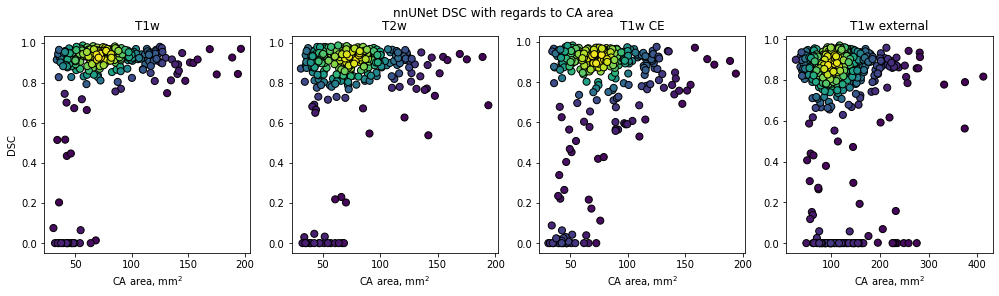

In [66]:
scatter_dice_area(scores_df_test_1, scores_df_t2w_1, scores_df_t1wce_1, scores_df_emc_1, 
                  nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc,
                  nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

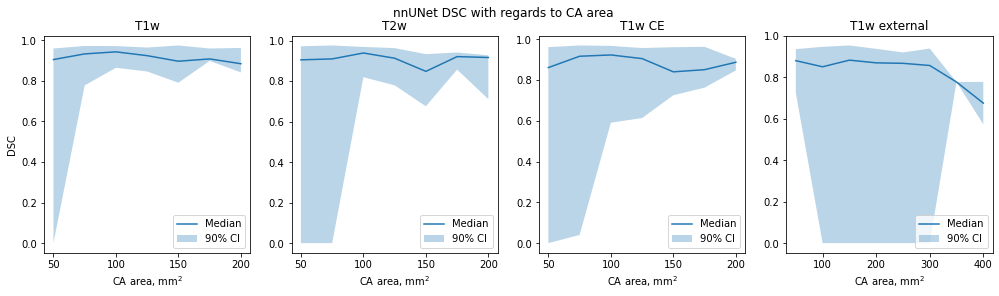

In [67]:
plot_dice_area(scores_df_test_1, scores_df_t2w_1, scores_df_t1wce_1, scores_df_emc_1, 
               nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc, 
               nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

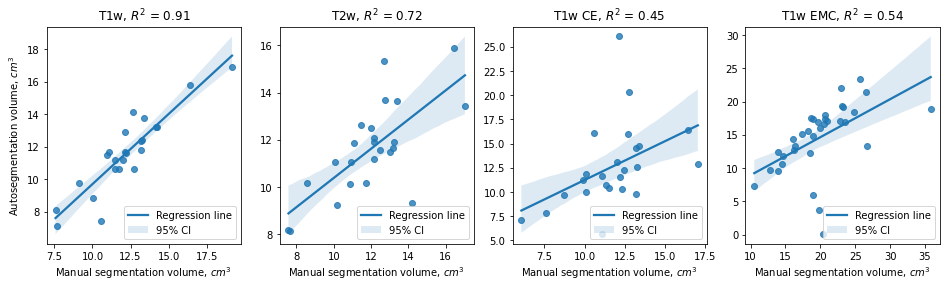

In [85]:
plot_volume_regression(scores_df_test_1, scores_df_t2w_1, scores_df_t1wce_1, scores_df_emc_1)

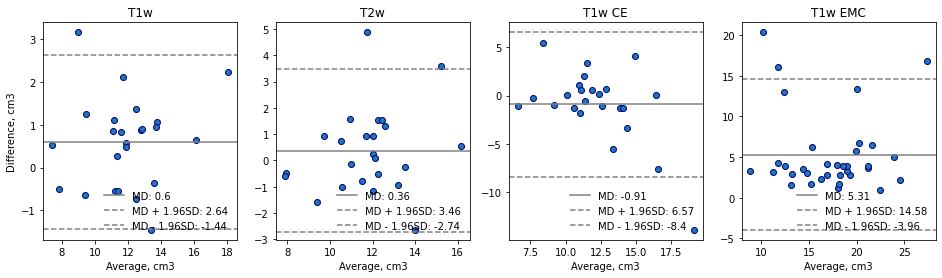

In [86]:
plot_ba(scores_df_test_1, scores_df_t2w_1, scores_df_t1wce_1, scores_df_emc_1)

## nnUnet+plaq-u-net_0

In [112]:
nifti_dirname_GT_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_GT"
nifti_dirname_GT_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_GT"
nifti_dirname_GT_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_GT"

nifti_dirname_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_plaqunet"
nifti_dirname_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_plaqunet"
nifti_dirname_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_plaqunet"
nifti_dirname_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_plaqunet"

nifti_dirname_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_plaqunet_p"
nifti_dirname_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_plaqunet_p"
nifti_dirname_t1wce_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_plaqunet_p"
nifti_dirname_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_plaqunet_p"

In [113]:
scores_median_test_2, scores_iqr_test_2, scores_df_test_2 = dirname2scores(nifti_dirname_GT_test, nifti_dirname_test, 
                                                                           nifti_dirname_test_sm,
                                                                           '../res/scores/metrics_plaqunet_test.csv')
scores_median_t2w_2, scores_iqr_t2w_2, scores_df_t2w_2 = dirname2scores(nifti_dirname_GT_t2w, nifti_dirname_t2w, 
                                                                        nifti_dirname_t2w_sm,
                                                                        '../res/scores/metrics_plaqunet_t2w.csv')
scores_median_t1wce_2, scores_iqr_t1wce_2, scores_df_t1wce_2 = dirname2scores(nifti_dirname_GT_t1wce, nifti_dirname_t1wce, 
                                                                              nifti_dirname_t1wce_sm,
                                                                              '../res/scores/metrics_plaqunet_t1wce.csv')
scores_median_emc_2, scores_iqr_emc_2, scores_df_emc_2 = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                        nifti_dirname_emc_sm,
                                                                        '../res/scores/metrics_plaqunet_emc.csv')

Process UMCU036.nii.gz ...: : 24it [00:18,  1.31it/s]
Process UMCU036.nii.gz ...: : 24it [00:20,  1.14it/s]
Process UMCU036.nii.gz ...: : 24it [00:19,  1.23it/s]
Process EMC057.nii.gz ...: : 34it [00:26,  1.27it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [114]:
scores_df_2 = pd.concat([scores_median_test_2, scores_iqr_test_2, 
                       scores_median_t2w_2, scores_iqr_t2w_2, 
                       scores_median_t1wce_2, scores_iqr_t1wce_2, 
                       scores_median_emc_2, scores_iqr_emc_2
                      ], axis=1)
scores_df_2.columns = ['test (median)', 'test (IQR)',
                     't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)'
                    ]
scores_df_2

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.918981,0.049565,0.897168,0.050211,0.886109,0.132079,0.867752,0.091954
jaccard,0.850111,0.082718,0.813524,0.082103,0.795518,0.200828,0.766398,0.140128
precision,0.934899,0.053017,0.902210,0.114515,0.879899,0.159107,0.971845,0.061717
recall,0.881139,0.097286,0.881928,0.094365,0.887489,0.247537,0.779130,0.148214
fpr,0.000389,0.000265,0.000590,0.000653,0.000708,0.001205,0.000232,0.000455
fnr,0.118861,0.097286,0.118072,0.094365,0.112510,0.247537,0.220870,0.148214
vs,0.074665,0.114309,0.011216,0.166415,-0.023410,0.198632,0.191117,0.157887
hd,2.278981,1.341168,2.518234,4.791547,3.374229,6.105804,7.088575,4.892117
msd,0.187475,0.219930,0.257958,0.431149,0.367589,0.627592,0.508131,0.309470
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.075758,0.273449,0.273453


In [115]:
print ('dd')
print (mean_squared_error(scores_df_test_2['volume_gt'], scores_df_test_2['volume_pred'], squared=False))
print (np.sum(scores_df_test_2['volume_gt']-scores_df_test_2['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t1wce_2['volume_gt'], scores_df_t1wce_2['volume_pred'], squared=False))
print (np.sum(scores_df_t1wce_2['volume_gt']-scores_df_t1wce_2['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t2w_2['volume_gt'], scores_df_t2w_2['volume_pred'], squared=False))
print (np.sum(scores_df_t2w_2['volume_gt']-scores_df_t2w_2['volume_pred'])/24)

print ('ed')
print (mean_squared_error(scores_df_emc_2['volume_gt'], scores_df_emc_2['volume_pred'], squared=False))
print (np.sum(scores_df_emc_2['volume_gt']-scores_df_emc_2['volume_pred'])/34)

dd
1514.8891323569965
523.1666666666666
d1
2410.947548855705
-133.33333333333334
d1
1542.9925604702917
429.9583333333333
ed
4731.076944927395
4029.0


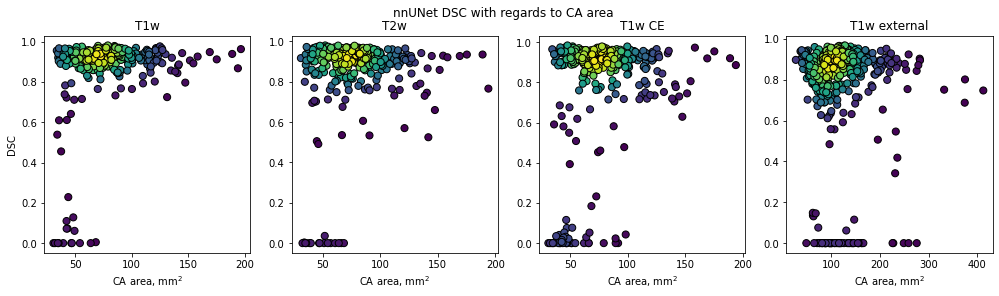

In [116]:
scatter_dice_area(scores_df_test_2, scores_df_t2w_2, scores_df_t1wce_2, scores_df_emc_2, 
                  nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc, 
                  nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

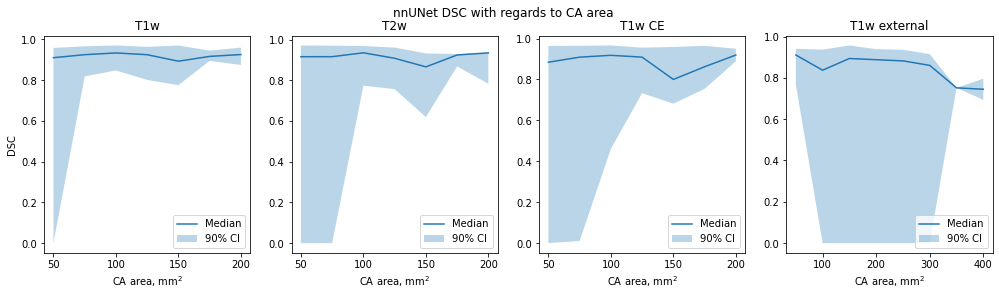

In [117]:
plot_dice_area(scores_df_test_2, scores_df_t2w_2, scores_df_t1wce_2, scores_df_emc_2, 
               nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc, 
               nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

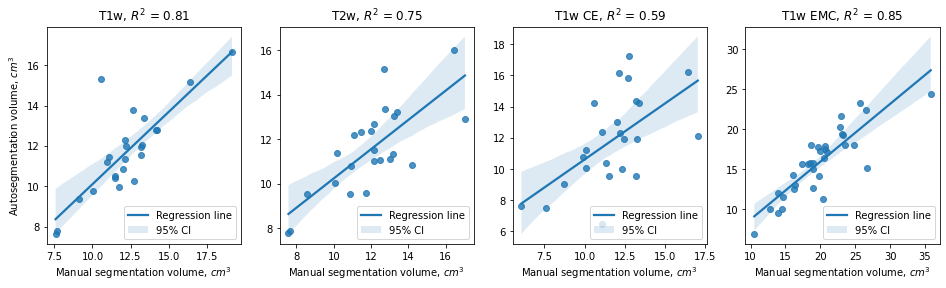

In [118]:
plot_volume_regression(scores_df_test_2, scores_df_t2w_2, scores_df_t1wce_2, scores_df_emc_2)

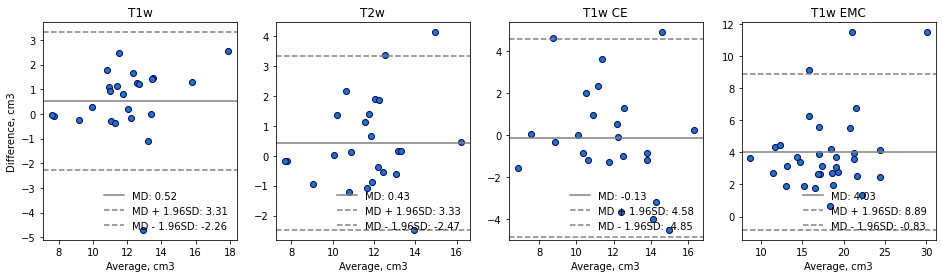

In [119]:
plot_ba(scores_df_test_2, scores_df_t2w_2, scores_df_t1wce_2, scores_df_emc_2)

## nnUnet+plaq-u-net+ul_4

In [97]:
nifti_dirname_GT_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_GT"
nifti_dirname_GT_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_GT"
nifti_dirname_GT_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_GT"

nifti_dirname_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_plaqumap"
nifti_dirname_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_plaqumap"
nifti_dirname_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_plaqumap"
nifti_dirname_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_plaqumap"

nifti_dirname_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\test\test_plaqumap_p"
nifti_dirname_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t2w\t2w_plaqumap_p"
nifti_dirname_t1wce_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\t1wce\t1wce_plaqumap_p"
nifti_dirname_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaqueuqalp\res\nifti_compare\emc\emc_plaqumap_p"

In [98]:
scores_median_test_3, scores_iqr_test_3, scores_df_test_3 = dirname2scores(nifti_dirname_GT_test, nifti_dirname_test, 
                                                                           nifti_dirname_test_sm,
                                                                           '../res/scores/metrics_test_plaqumap.csv')
scores_median_t2w_3, scores_iqr_t2w_3, scores_df_t2w_3 = dirname2scores(nifti_dirname_GT_t2w, nifti_dirname_t2w, 
                                                                        nifti_dirname_t2w_sm,
                                                                        '../res/scores/metrics_t2w_plaqumap.csv')
scores_median_t1wce_3, scores_iqr_t1wce_3, scores_df_t1wce_3 = dirname2scores(nifti_dirname_GT_t1wce, nifti_dirname_t1wce, 
                                                                              nifti_dirname_t1wce_sm,
                                                                              '../res/scores/metrics_t1wce_plaqumap.csv')
scores_median_emc_3, scores_iqr_emc_3, scores_df_emc_3 = dirname2scores(nifti_dirname_GT_emc, nifti_dirname_emc, 
                                                                        nifti_dirname_emc_sm,
                                                                        '../res/scores/metrics_emc_plaqumap.csv')

Process UMCU036.nii.gz ...: : 24it [00:18,  1.31it/s]
Process UMCU036.nii.gz ...: : 24it [00:21,  1.13it/s]
Process UMCU036.nii.gz ...: : 24it [00:21,  1.14it/s]
Process EMC057.nii.gz ...: : 34it [00:26,  1.29it/s]
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [99]:
scores_df_3 = pd.concat([scores_median_test_3, scores_iqr_test_3, 
                       scores_median_t2w_3, scores_iqr_t2w_3, 
                       scores_median_t1wce_3, scores_iqr_t1wce_3, 
                       scores_median_emc_3, scores_iqr_emc_3
                      ], axis=1)
scores_df_3.columns = ['test (median)', 'test (IQR)',
                     't2w (median)', 't2w (IQR)', 
                     't1wce (median)', 't1wce (IQR)', 'emc (median)', 'emc (IQR)'
                    ]
scores_df_3

,test (median),test (IQR),t2w (median),t2w (IQR),t1wce (median),t1wce (IQR),emc (median),emc (IQR)
dice,0.916969,0.033135,0.897661,0.050854,0.891752,0.113600,0.894002,0.067377
jaccard,0.846674,0.055896,0.814423,0.083896,0.804656,0.174980,0.808322,0.106654
precision,0.893039,0.072100,0.879915,0.112428,0.844850,0.143303,0.962945,0.057104
recall,0.912335,0.073025,0.922253,0.083382,0.923767,0.220369,0.833277,0.120914
fpr,0.000649,0.000380,0.000760,0.000715,0.000964,0.001285,0.000297,0.000381
fnr,0.087664,0.073025,0.077747,0.083382,0.076233,0.220369,0.166723,0.120914
vs,-0.012016,0.136829,-0.048403,0.150816,-0.102525,0.215776,0.147523,0.146767
hd,2.185182,2.301241,2.545199,5.934103,3.594207,6.332442,6.988188,4.629297
msd,0.190142,0.176341,0.280142,0.245932,0.387510,0.578774,0.464929,0.322643
mdsd,0.000000,0.000000,0.000000,0.000000,0.000000,0.075757,0.273445,0.273449


In [100]:
print ('dd')
print (mean_squared_error(scores_df_test_3['volume_gt'], scores_df_test_3['volume_pred'], squared=False))
print (np.sum(scores_df_test_3['volume_gt']-scores_df_test_3['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t1wce_3['volume_gt'], scores_df_t1wce_3['volume_pred'], squared=False))
print (np.sum(scores_df_t1wce_3['volume_gt']-scores_df_t1wce_3['volume_pred'])/24)

print ('d1')
print (mean_squared_error(scores_df_t2w_3['volume_gt'], scores_df_t2w_3['volume_pred'], squared=False))
print (np.sum(scores_df_t2w_3['volume_gt']-scores_df_t2w_3['volume_pred'])/24)

print ('ed')
print (mean_squared_error(scores_df_emc_3['volume_gt'], scores_df_emc_3['volume_pred'], squared=False))
print (np.sum(scores_df_emc_3['volume_gt']-scores_df_emc_3['volume_pred'])/34)

dd
1313.8928958125418
-235.54166666666666
d1
2454.396989758041
-958.5833333333334
d1
1490.662869889321
-338.0416666666667
ed
3949.007164875153
3115.705882352941


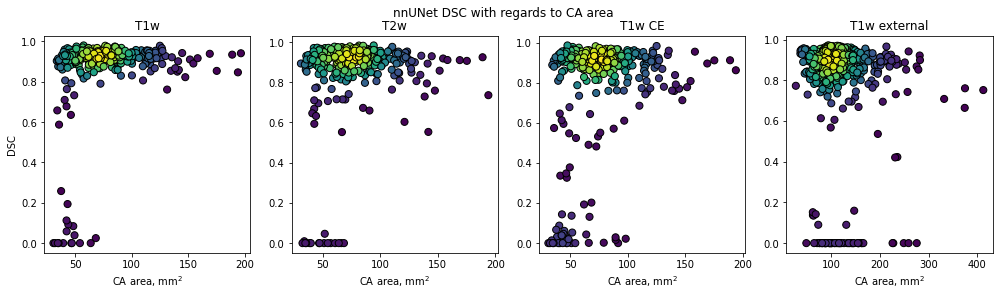

In [101]:
scatter_dice_area(scores_df_test_3, scores_df_t2w_3, scores_df_t1wce_3, scores_df_emc_3, 
                  nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc,
                  nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

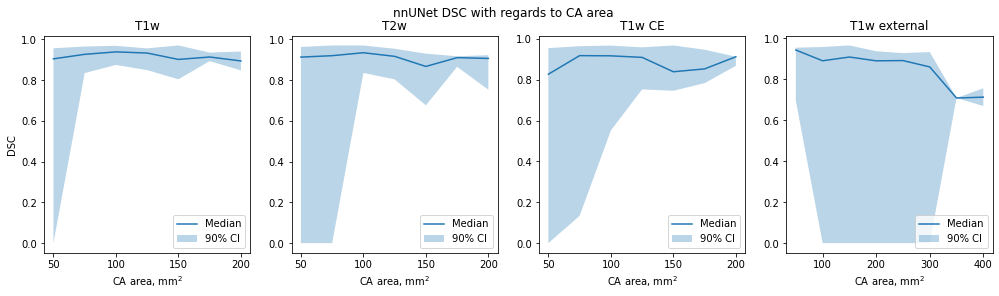

In [102]:
plot_dice_area(scores_df_test_3, scores_df_t2w_3, scores_df_t1wce_3, scores_df_emc_3, 
               nifti_dirname_GT_test, nifti_dirname_GT_t2w, nifti_dirname_GT_t1wce, nifti_dirname_GT_emc, 
               nifti_dirname_test, nifti_dirname_t2w, nifti_dirname_t1wce, nifti_dirname_emc)

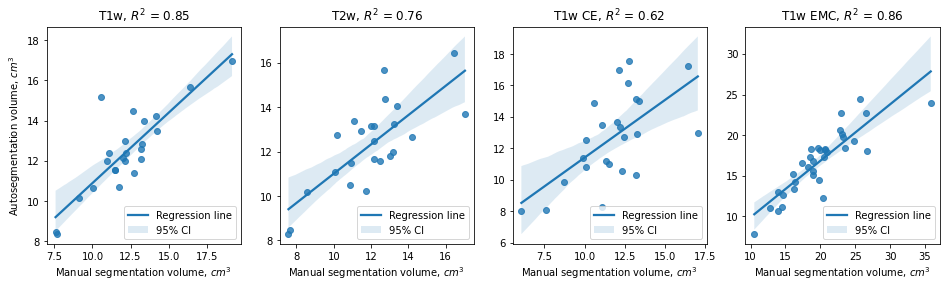

In [103]:
plot_volume_regression(scores_df_test_3, scores_df_t2w_3, scores_df_t1wce_3, scores_df_emc_3)

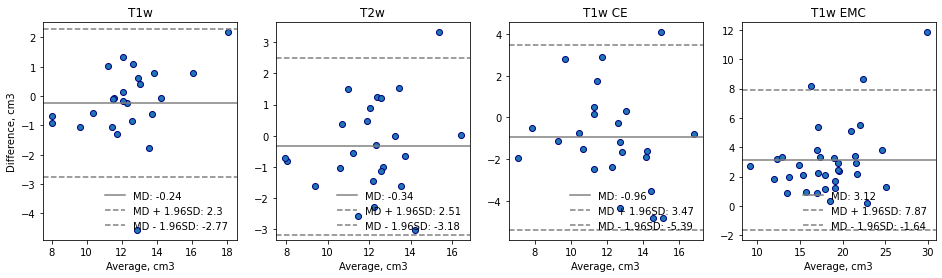

In [104]:
plot_ba(scores_df_test_3, scores_df_t2w_3, scores_df_t1wce_3, scores_df_emc_3)

0.8604993971299594
0.8550964098943802
0.8522031143007575
0.7959371368512203


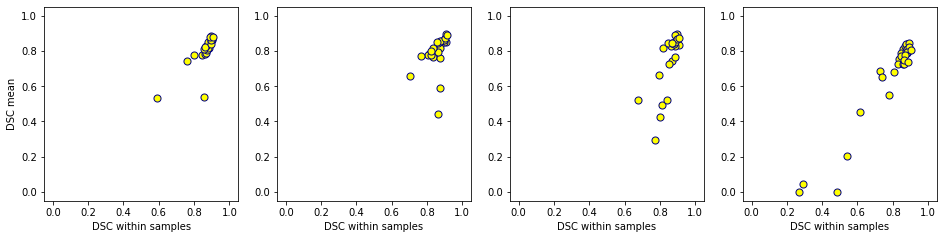

In [218]:
plt.figure(figsize=(16, 4))

plt.subplot(141)
get_dropout_dice("C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/test/test_GT/", 
                 "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/test/test_plaqumap_dropout/")

plt.subplot(142)
get_dropout_dice("C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_GT/", 
                 "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_plaqumap_dropout/")
plt.ylabel('')

plt.subplot(143)
get_dropout_dice("C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t1wce/t1wce_GT/", 
                 "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t1wce/t1wce_plaqumap_dropout/")
plt.ylabel('')

plt.subplot(144)
get_dropout_dice("C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/emc/emc_GT/", 
                 "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/emc/emc_plaqumap_dropout/")
plt.ylabel('')

plt.show()

## Comparison

In [106]:
ds_1 = pd.DataFrame(scores_df_test_1['dice'], columns=['dice'])
ds_1['model'] = 'nnUNet'
ds_1['domain'] = 'T1w'

ds_2 = pd.DataFrame(scores_df_t2w_1['dice'], columns=['dice'])
ds_2['model'] = 'nnUNet'
ds_2['domain'] = 'T2w'

ds_3 = pd.DataFrame(scores_df_t1wce_1['dice'], columns=['dice'])
ds_3['model'] = 'nnUNet'
ds_3['domain'] = 'T1w CE'

ds_4 = pd.DataFrame(scores_df_emc_1['dice'], columns=['dice'])
ds_4['model'] = 'nnUNet'
ds_4['domain'] = 'T1w EMC'

ds_5 = pd.DataFrame(scores_df_test_2['dice'], columns=['dice'])
ds_5['model'] = 'plaq-u-net'
ds_5['domain'] = 'T1w'

ds_6 = pd.DataFrame(scores_df_t2w_2['dice'], columns=['dice'])
ds_6['model'] = 'plaq-u-net'
ds_6['domain'] = 'T2w'

ds_7 = pd.DataFrame(scores_df_t1wce_2['dice'], columns=['dice'])
ds_7['model'] = 'plaq-u-net'
ds_7['domain'] = 'T1w CE'

ds_8 = pd.DataFrame(scores_df_emc_2['dice'], columns=['dice'])
ds_8['model'] = 'plaq-u-net'
ds_8['domain'] = 'T1w EMC'

ds_9 = pd.DataFrame(scores_df_test_3['dice'], columns=['dice'])
ds_9['model'] = 'plaq-uncertainty-net'
ds_9['domain'] = 'T1w'

ds_10 = pd.DataFrame(scores_df_t2w_3['dice'], columns=['dice'])
ds_10['model'] = 'plaq-uncertainty-net'
ds_10['domain'] = 'T2w'

ds_11 = pd.DataFrame(scores_df_t1wce_3['dice'], columns=['dice'])
ds_11['model'] = 'plaq-uncertainty-net'
ds_11['domain'] = 'T1w CE'

ds_12 = pd.DataFrame(scores_df_emc_3['dice'], columns=['dice'])
ds_12['model'] = 'plaq-uncertainty-net'
ds_12['domain'] = 'T1w EMC'

In [107]:
df = pd.concat([ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10, ds_11, ds_12], axis=0)

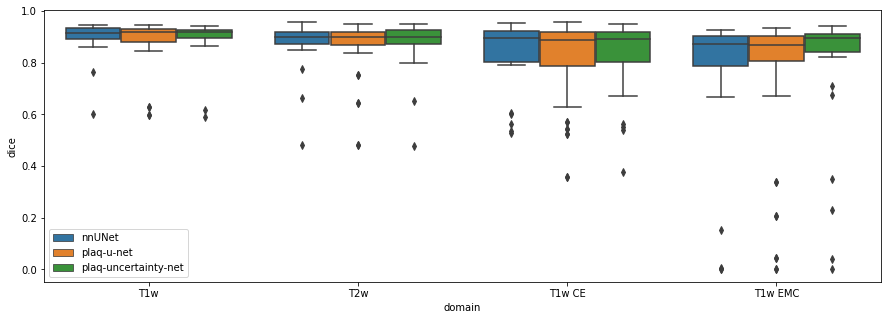

In [108]:
import seaborn as sns

#sns.set_context('notebook')
plt.figure(figsize=(15, 5))
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="domain", y="dice",
            hue="model", 
            data=df)
plt.legend(loc='lower left')
plt.show()

In [20]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 
                 'EMC015', 'EMC018', 'EMC020', 'EMC024', 'EMC027', 'EMC029', 'EMC031', 
                 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 'EMC042', 
                 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 
                 'EMC051', 'EMC052', 'EMC054', 'EMC055', 'EMC056', 'EMC057']

In [21]:
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [23]:
sub_name

'AMC006'

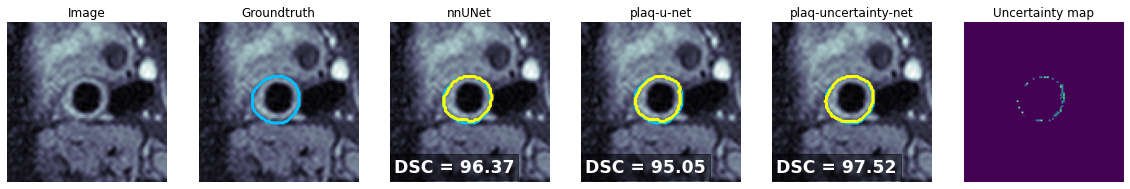

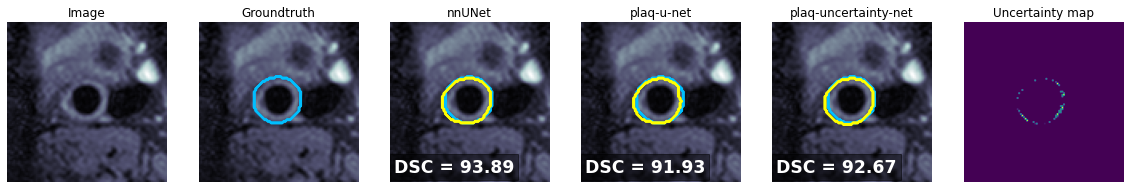

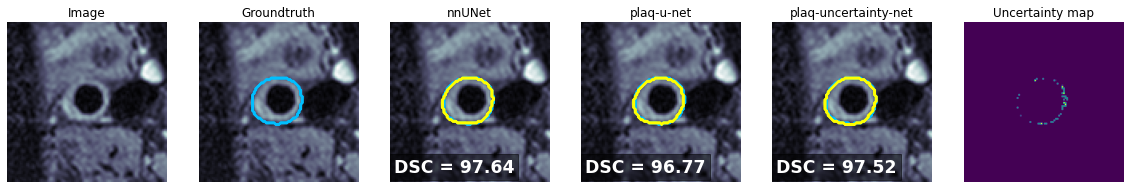

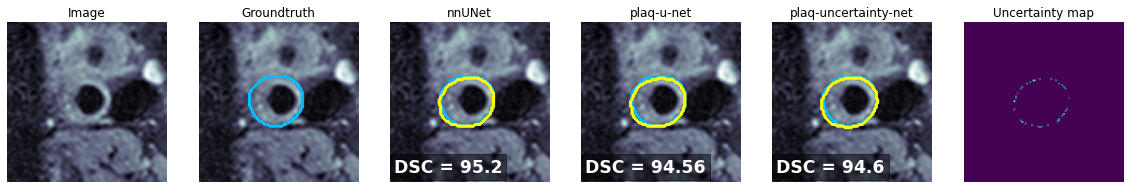

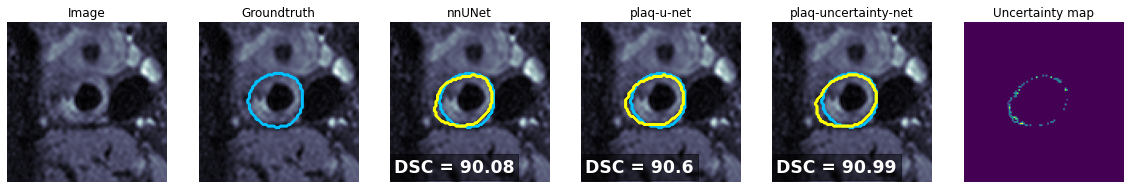

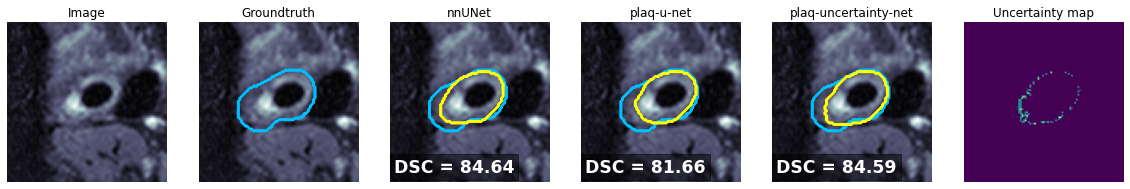

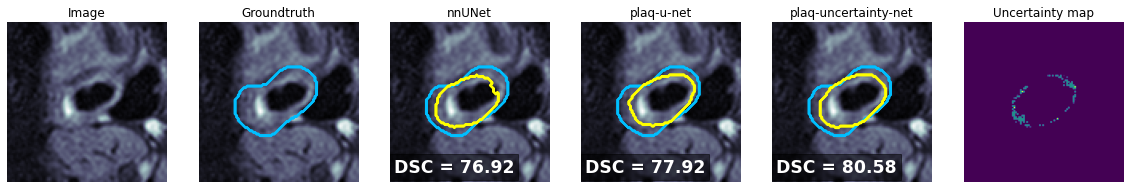

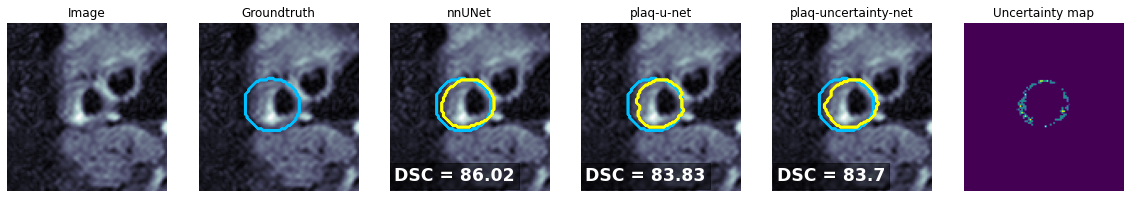

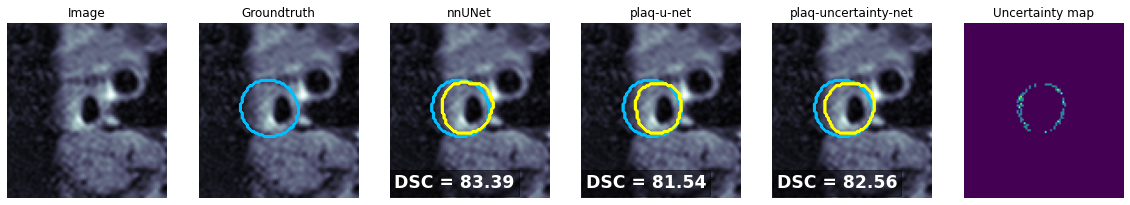

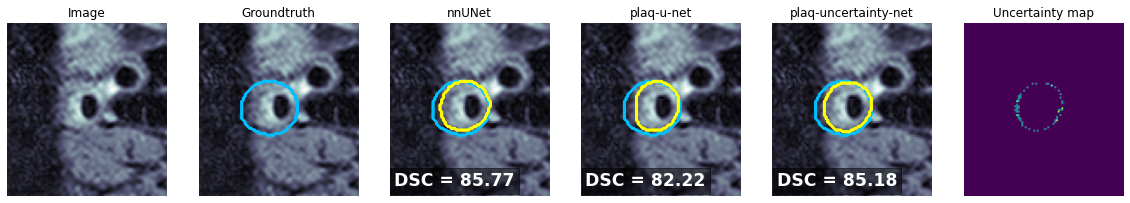

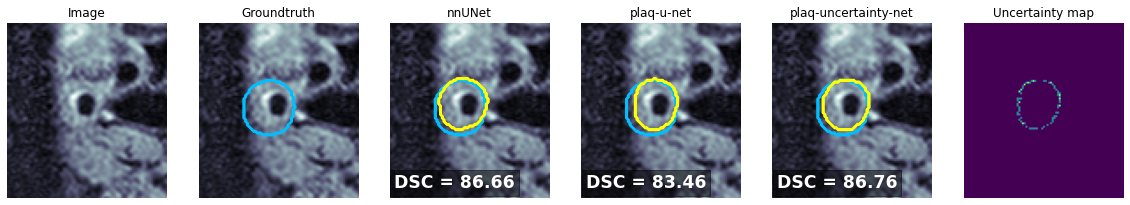

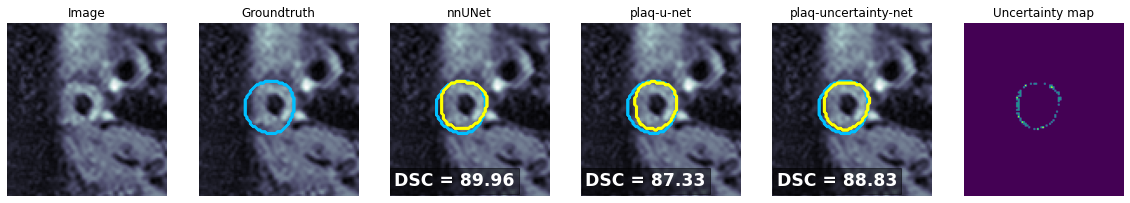

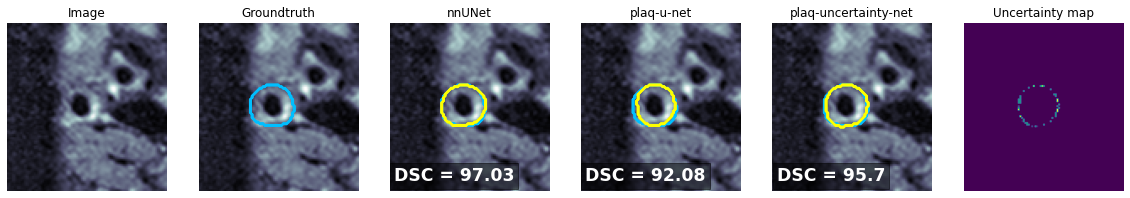

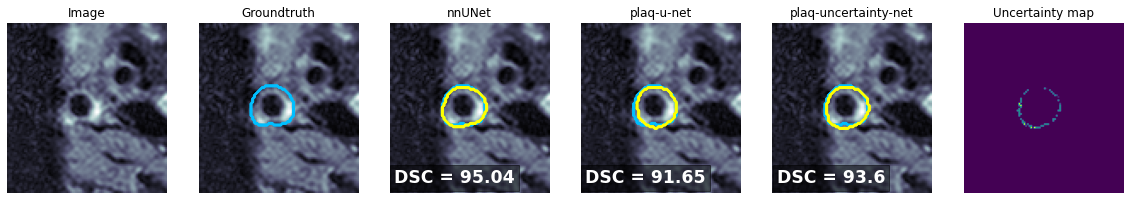

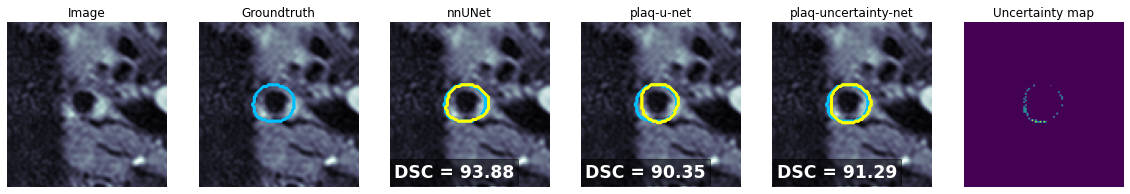

ValueError: could not broadcast input array from shape (256,512,14) into shape (256,512,15)

In [22]:
for sub_name in sub_names_test:

    filename_img = "D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/imagesTs2/"+sub_name+"_0000.nii.gz"
    filename_gt = "D:/Lisa/nnUNet_raw_data_base/nnUNet_raw_data/Task001_CA/labelsTs2/"+sub_name+".nii.gz"
    filename_nnunet = "D:/Lisa/nnUNet_raw_data_base/nnUNet_results/Ts2/"+sub_name+".nii.gz"
    filename_plaqunet = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_plaqunet/"+sub_name+".nii.gz"
    filename_plaquncertaintynet = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_plaqumap/"+sub_name+".nii.gz"
    do_filenames = glob.glob("C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_plaqumap_dropout/"+sub_name+"_*.nii.gz")

    img_nii = nib.load(filename_img)
    gt_nii = nib.load(filename_gt)
    nnunet_nii = nib.load(filename_nnunet)
    plaqunet_nii = nib.load(filename_plaqunet)
    plaquncertaintynet_nii = nib.load(filename_plaquncertaintynet)

    img = img_nii.get_fdata()
    gt = gt_nii.get_fdata()
    nnunet = nnunet_nii.get_fdata()
    plaqunet = plaqunet_nii.get_fdata()
    plaquncertaintynet = plaquncertaintynet_nii.get_fdata()

    dim = img.shape
    n = len(do_filenames)

    pred_do = np.zeros((dim[0], dim[1], dim[2], n), dtype = np.float32)

    for i in range (0, n):
        pred_do[..., i] = nib.load(do_filenames[i]).get_fdata()

    pred_do_mean = np.mean(pred_do, axis = 3)
    pred_do_std = np.std(pred_do, axis = 3)

    for sl in range (0, gt.shape[-1]):

        coords_gt = np.where(gt[..., sl]>0)

        x_c_gt = np.mean(coords_gt[0])
        y_c_gt = np.mean(coords_gt[1])

        x_min = int(x_c_gt-50)
        x_max = int(x_c_gt+50)

        y_min = int(y_c_gt-50)
        y_max = int(y_c_gt+50)

        plt.figure(figsize=(20, 10))

        gt_slice = morphology.remove_small_holes(np.rot90(gt[x_min:x_max, y_min:y_max, sl].T, k=2)>0.9, 25)

        dsc_1 = round(calculate_dice(gt_slice, np.rot90(nnunet[x_min:x_max, y_min:y_max, sl].T, k=2)>0)*100, 2)
        dsc_2 = round(calculate_dice(gt_slice, np.rot90(plaqunet[x_min:x_max, y_min:y_max, sl].T, k=2)>0)*100, 2)
        dsc_3 = round(calculate_dice(gt_slice, np.rot90(plaquncertaintynet[x_min:x_max, y_min:y_max, sl].T, k=2)>0)*100, 2)

        plt.subplot(161)
        plt.imshow(np.rot90(img[x_min:x_max, y_min:y_max, sl].T, k=2), cmap='bone')
        plt.axis('off')
        plt.title('Image')
        plt.subplot(162)
        plt.imshow(np.rot90(img[x_min:x_max, y_min:y_max, sl].T, k=2), cmap='bone')
        plt.contour(gt_slice, colors='deepskyblue')
        plt.axis('off')
        plt.title('Groundtruth')
        plt.subplot(163)
        plt.imshow(np.rot90(img[x_min:x_max, y_min:y_max, sl].T, k=2), cmap='bone')
        plt.contour(gt_slice, colors='deepskyblue')
        plt.contour(np.rot90(nnunet[x_min:x_max, y_min:y_max, sl].T, k=2)>0, colors='yellow')
        plt.text(2, 96, 'DSC = '+str(dsc_1), color = 'w',va ='bottom',ha='left',fontweight='semibold',fontsize='xx-large',
                 bbox=dict(facecolor='k', edgecolor='k', alpha=0.5))
        plt.axis('off')
        plt.title('nnUNet')
        plt.subplot(164)
        plt.imshow(np.rot90(img[x_min:x_max, y_min:y_max, sl].T, k=2), cmap='bone')
        plt.contour(gt_slice, colors='deepskyblue')
        plt.contour(np.rot90(plaqunet[x_min:x_max, y_min:y_max, sl].T, k=2)>0, colors='yellow')
        plt.text(2, 96, 'DSC = '+str(dsc_2), color = 'w',va ='bottom',ha='left',fontweight='semibold',fontsize='xx-large',
                bbox=dict(facecolor='k', edgecolor='k', alpha=0.5))
        plt.axis('off')
        plt.title('plaq-u-net')
        plt.subplot(165)
        plt.imshow(np.rot90(img[x_min:x_max, y_min:y_max, sl].T, k=2), cmap='bone')
        plt.contour(gt_slice, colors='deepskyblue')
        plt.contour(np.rot90(plaquncertaintynet[x_min:x_max, y_min:y_max, sl].T, k=2)>0, colors='yellow')
        plt.text(2, 96, 'DSC = '+str(dsc_3), color = 'w',va ='bottom',ha='left',fontweight='semibold',fontsize='xx-large',
                bbox=dict(facecolor='k', edgecolor='k', alpha=0.5))
        plt.axis('off')
        plt.title('plaq-uncertainty-net')
        plt.subplot(166)
        plt.imshow(np.rot90(pred_do_std[x_min:x_max, y_min:y_max, sl].T, k=2))
        plt.axis('off')
        plt.title('Uncertainty map')
        plt.show()

In [120]:
def compare_res(x_1, x_2):
    #U, p  = stats.ttest_rel(x_1, x_2)
    #U, p  = mannwhitneyu(x_1, x_2)
    U, p = stats.wilcoxon(x_1, x_2, zero_method = 'wilcox')
    #U, p = stats.kruskal(x_1, x_2)
    #stat, p, med, tbl = stats.median_test(x_1, x_2)
    return p

In [121]:
print ('DSC')
#p = compare_res(scores_df_test_1['dice'], scores_df_test_2['dice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_test_2['dice'], scores_df_test_3['dice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_test_1['dice'], scores_df_test_3['dice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('clDSC')
#p = compare_res(scores_df_test_1['clDice'], scores_df_test_2['clDice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_test_2['clDice'], scores_df_test_3['clDice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_test_1['clDice'], scores_df_test_3['clDice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('HD')
#p = compare_res(scores_df_test_1['hd'], scores_df_test_2['hd'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_test_2['hd'], scores_df_test_3['hd'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_test_1['hd'], scores_df_test_3['hd'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('volume_error')
#p = compare_res(scores_df_test_1['volume_error'], scores_df_test_2['volume_error'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_test_2['volume_error'], scores_df_test_3['volume_error'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_test_1['volume_error'], scores_df_test_3['volume_error'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('NSD')
#p = compare_res(scores_df_test_1['NSD'], scores_df_test_2['NSD'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_test_2['NSD'], scores_df_test_3['NSD'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_test_1['NSD'], scores_df_test_3['NSD'])
print ('nnUNet vs plaq-uncertainty-net: ', p)


DSC
nnUNet vs plaq-uncertainty-net:  0.15998530387878418
clDSC
nnUNet vs plaq-uncertainty-net:  0.46911315243545415
HD
nnUNet vs plaq-uncertainty-net:  0.6012127057398096
volume_error
nnUNet vs plaq-uncertainty-net:  0.4223414659500122
NSD
nnUNet vs plaq-uncertainty-net:  0.8553357124328613


C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [122]:
print ('DSC')
#p = compare_res(scores_df_t2w_1['dice'], scores_df_t2w_2['dice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t2w_2['dice'], scores_df_t2w_3['dice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t2w_1['dice'], scores_df_t2w_3['dice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('clDSC')
#p = compare_res(scores_df_t2w_1['clDice'], scores_df_t2w_2['clDice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t2w_2['clDice'], scores_df_t2w_3['clDice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t2w_1['clDice'], scores_df_t2w_3['clDice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('HD')
#p = compare_res(scores_df_t2w_1['hd'], scores_df_t2w_2['hd'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t2w_2['hd'], scores_df_t2w_3['hd'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t2w_1['hd'], scores_df_t2w_3['hd'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('volume_error')
#p = compare_res(scores_df_t2w_1['volume_error'], scores_df_t2w_2['volume_error'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t2w_2['volume_error'], scores_df_t2w_3['volume_error'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t2w_1['volume_error'], scores_df_t2w_3['volume_error'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('NSD')
#p = compare_res(scores_df_t2w_1['NSD'], scores_df_t2w_2['NSD'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t2w_2['NSD'], scores_df_t2w_3['NSD'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t2w_1['NSD'], scores_df_t2w_3['NSD'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

DSC
nnUNet vs plaq-uncertainty-net:  0.6634435653686523
clDSC
nnUNet vs plaq-uncertainty-net:  0.5829195472688132
HD
nnUNet vs plaq-uncertainty-net:  0.670246776722805
volume_error
nnUNet vs plaq-uncertainty-net:  0.4389305114746094
NSD
nnUNet vs plaq-uncertainty-net:  0.584056453701191


In [123]:
print ('DSC')
#p = compare_res(scores_df_t1wce_1['dice'], scores_df_t1wce_2['dice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t1wce_2['dice'], scores_df_t1wce_3['dice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t1wce_1['dice'], scores_df_t1wce_3['dice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('clDSC')
#p = compare_res(scores_df_t1wce_1['clDice'], scores_df_t1wce_2['clDice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t1wce_2['clDice'], scores_df_t1wce_3['clDice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t1wce_1['clDice'], scores_df_t1wce_3['clDice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('HD')
#p = compare_res(scores_df_t1wce_1['hd'], scores_df_t1wce_2['hd'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t1wce_2['hd'], scores_df_t1wce_3['hd'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t1wce_1['hd'], scores_df_t1wce_3['hd'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('volume_error')
#p = compare_res(scores_df_t1wce_1['volume_error'], scores_df_t1wce_2['volume_error'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t1wce_2['volume_error'], scores_df_t1wce_3['volume_error'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t1wce_1['volume_error'], scores_df_t1wce_3['volume_error'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('NSD')
#p = compare_res(scores_df_t1wce_1['NSD'], scores_df_t1wce_2['NSD'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_t1wce_2['NSD'], scores_df_t1wce_3['NSD'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_t1wce_1['NSD'], scores_df_t1wce_3['NSD'])
print ('nnUNet vs plaq-uncertainty-net: ', p)


DSC
nnUNet vs plaq-uncertainty-net:  0.28966712951660156
clDSC
nnUNet vs plaq-uncertainty-net:  0.04373288761671472
HD
nnUNet vs plaq-uncertainty-net:  0.9031748075260909
volume_error
nnUNet vs plaq-uncertainty-net:  0.8553357124328613
NSD
nnUNet vs plaq-uncertainty-net:  0.9664472341537476


In [124]:
print ('DSC')
#p = compare_res(scores_df_emc_1['dice'], scores_df_emc_2['dice'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_emc_2['dice'], scores_df_emc_3['dice'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_emc_1['dice'], scores_df_emc_3['dice'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('clDSC')
#p = compare_res(scores_df_emc_1['clDice'][~np.isnan(scores_df_emc_1['clDice'])], 
#                scores_df_emc_2['clDice'][~np.isnan(scores_df_emc_2['clDice'])]) 
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_emc_3['clDice'][~np.isnan(scores_df_emc_3['clDice'])], 
#                scores_df_emc_2['clDice'][~np.isnan(scores_df_emc_2['clDice'])])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_emc_1['clDice'][~np.isnan(scores_df_emc_1['clDice'])], 
                scores_df_emc_3['clDice'][~np.isnan(scores_df_emc_3['clDice'])])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('NSD')
#p = compare_res(scores_df_emc_1['NSD'], scores_df_emc_2['NSD'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_emc_2['NSD'], scores_df_emc_3['NSD'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_emc_1['NSD'], scores_df_emc_3['NSD'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('HD')
#p = compare_res(scores_df_emc_1['hd'], scores_df_emc_2['hd'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_emc_2['hd'], scores_df_emc_3['hd'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_emc_1['hd'], scores_df_emc_3['hd'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

print ('volume_error')
#p = compare_res(scores_df_emc_1['volume_error'], scores_df_emc_2['volume_error'])
#print ('nnUNet vs plaq-u-net: ', p)
#p = compare_res(scores_df_emc_2['volume_error'], scores_df_emc_3['volume_error'])
#print ('plaq-u-net vs plaq-uncertainty-net: ', p)
p = compare_res(scores_df_emc_1['volume_error'], scores_df_emc_3['volume_error'])
print ('nnUNet vs plaq-uncertainty-net: ', p)

DSC
nnUNet vs plaq-uncertainty-net:  6.639428259340563e-06
clDSC
nnUNet vs plaq-uncertainty-net:  0.6615589548322263
NSD
nnUNet vs plaq-uncertainty-net:  0.0009390588255952611
HD
nnUNet vs plaq-uncertainty-net:  0.8450804241615161
volume_error
nnUNet vs plaq-uncertainty-net:  4.371614103328839e-07
